# 🔍 Predicting Item Prices from Descriptions (Part 4)
---
-  Data Curation & Preprocessing
- Model Benchmarking – Traditional ML vs LLMs
- E5 Embeddings & RAG
- ➡️ Fine-Tuning GPT-4o Mini
- Evaluating LLaMA 3.1 8B Quantized
- Fine-Tuning LLaMA 3.1 with QLoRA
- Evaluating Fine-Tuned LLaMA
- Summary & Leaderboard

---

# 🔧 Part 4: Fine-Tuning GPT-4o Mini

- 🧑‍💻 Skill Level: Advanced
- ⚙️ Hardware: ✅ CPU is sufficient — no GPU required
- 🛠️ Requirements: 🔑 HF Token, Open API Key, wandb API Key
- Tasks:
    - Convert chat data to .jsonl format for OpenAI
    - Fine-tune the model and monitor with Weights & Biases
    - Test the fine-tuned GPT-4o Mini 

Can fine-tuning GPT-4o Mini outperform both its zero-shot baseline and RAG-enhanced version?  
Time to find out.

---
📢 Find more LLM notebooks on my [GitHub repository](https://github.com/lisekarimi/lexo)

In [ ]:
# imports

import os
import importlib
import json
import re
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset
from openai import OpenAI

In [ ]:
load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if not openai_api_key:
   print("❌ OPENAI_API_KEY is missing")

openai = OpenAI(api_key=openai_api_key)

hf_token = os.getenv('HF_TOKEN')
if not hf_token:
   print("❌ HF_TOKEN is missing")

login(hf_token, add_to_git_credential=True)

## 📥 Load Dataset

In [ ]:
# #If you face NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported run:
# %pip install -U datasets

In [ ]:
HF_USER = "lisekarimi"
DATASET_NAME = f"{HF_USER}/pricer-data"

dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [ ]:
test[0]

## 🛠️ Step 1 : Data Preparation

To fine-tune GPT-4o-mini, OpenAI requires training data in **.jsonl format**. 

`make_jsonl` converts our chat data :

from 

[
  {"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"},
  {"role": "user", "content": "How much is this laptop worth?"},
  {"role": "assistant", "content": "Price is $999.00"}
]

into the .jsonl format 

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much is this laptop worth?"}, {"role": "assistant", "content": "Price is $999.00"}]}


In [ ]:
# Mask the price in the test item
def mask_price_value(text):
    return re.sub(r"(\n\nPrice is \$).*", r"\1", text)

In [ ]:
def messages_for(datapoint):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = mask_price_value(datapoint["text"]).replace(" to the nearest dollar", "").replace("\n\nPrice is $","")
    assistant_response = f"Price is ${datapoint['price']:.2f}"
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": assistant_response}
    ]

messages_for(train[0])

In [ ]:
def make_jsonl(datapoints):
    result = ""
    for datapoint in datapoints:
        messages = messages_for(datapoint)
        messages_str = json.dumps(messages, ensure_ascii=False)
        result += '{"messages": ' + messages_str + '}\n'
    return result.strip()

make_jsonl(train.select([0]))

In [ ]:
ft_train = train.select(range(100))
ft_validation = train.select(range(100, 150))

In [ ]:
# Convert the items into jsonl and write them to a file

def write_jsonl(datapoints, filename):
    with open(filename, "w", encoding="utf-8") as f:
        jsonl = make_jsonl(datapoints)
        f.write(jsonl)

In [ ]:
write_jsonl(ft_train, "data/ft_train.jsonl")
write_jsonl(ft_validation, "data/ft_val.jsonl")

In [ ]:
with open("data/ft_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")
with open("data/ft_val.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [ ]:
train_file

In [ ]:
validation_file

## 🚀 Step 2: Run Fine-Tuning & Monitor with wandb
We will use https://wandb.ai to monitor the training runs

1- Create an API key in wandb

2- Add this key in OpenAI dashboard https://platform.openai.com/account/organization

In [ ]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [ ]:
# Run the fine tuning

openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

In [ ]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id
job_id

# Then check your wandb dashboard to view the run of this job ID

In [ ]:
# Use this command to track the fine-tuning progress here

openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=2).data

# 📧 You’ll get an email once fine-tuning is complete. ☕ You can take a break until then. ▶️ Once you receive it, run the cells below to continue.

## Step 3 : Test the fine tuned model

In [ ]:
ft_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model
ft_model_name

You can find the entire fine-tuning process in the **Fine-tuning** dashboard on OpenAI.

![Fine-tuning Process](https://github.com/lisekarimi/lexo/blob/main/assets/09_ft_gpt4omini.png?raw=true)


and on wandb: 

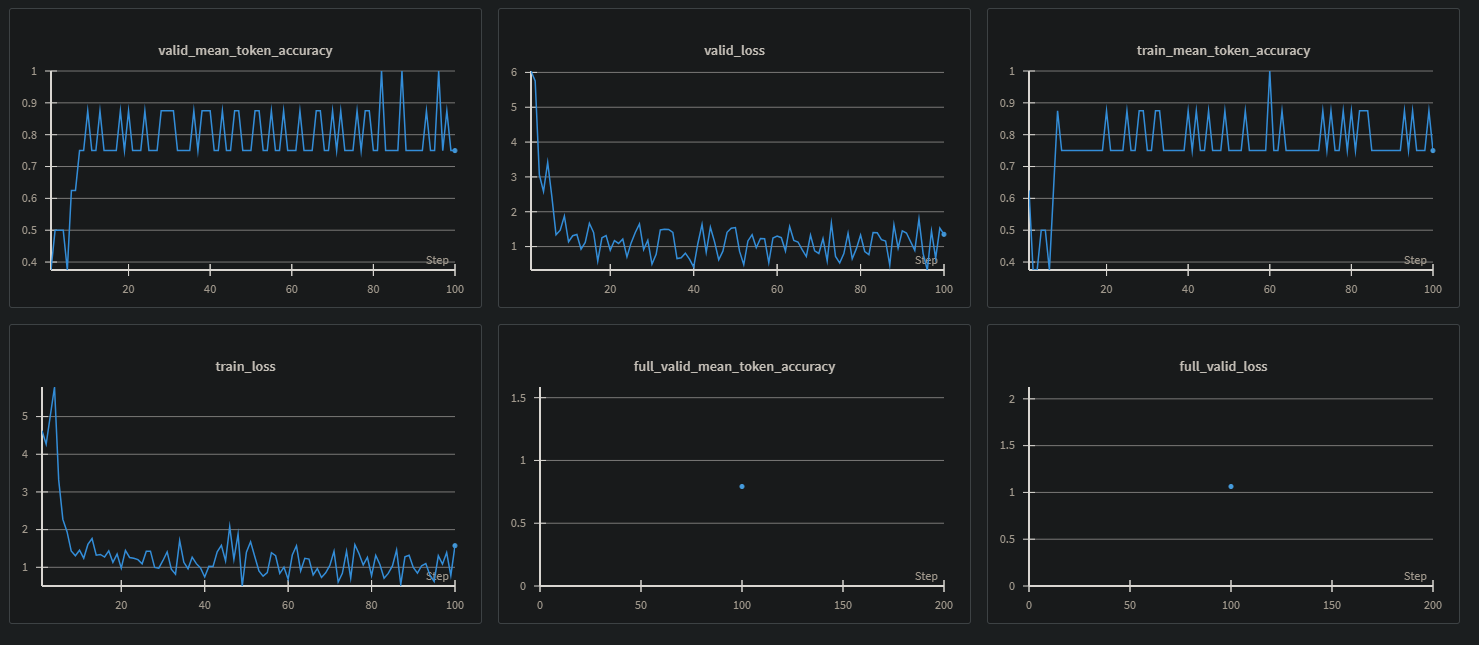

In [ ]:
# Build LLM messages
def build_messages(datapoint):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = mask_price_value(datapoint["text"]).replace(" to the nearest dollar", "").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

def gpt_ft(datapoint):
    response = openai.chat.completions.create(
        model=ft_model_name,
        messages=build_messages(datapoint),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [ ]:
print(test[0]["price"])
print(gpt_ft(test[0]))

🔔 **Reminder:**  
- In **Part 2**, GPT-4o Mini (zero-shot) scored:  
  Avg. Error: ~$99 | RMSLE: 0.75 | Accuracy: 44.8%  

- In **Part 3**, with **RAG**, performance improved to:  
  Avg. Error: ~$59.54 | RMSLE: 0.42 | Accuracy: 69.2%

🧪 **Now it’s time to see** if fine-tuning can push GPT-4o Mini even further and outperform both baselines.

In [ ]:
import helpers.testing
importlib.reload(helpers.testing)

from helpers.testing import Tester  # noqa: E402

tester = Tester(gpt_ft, test)
tester.run()

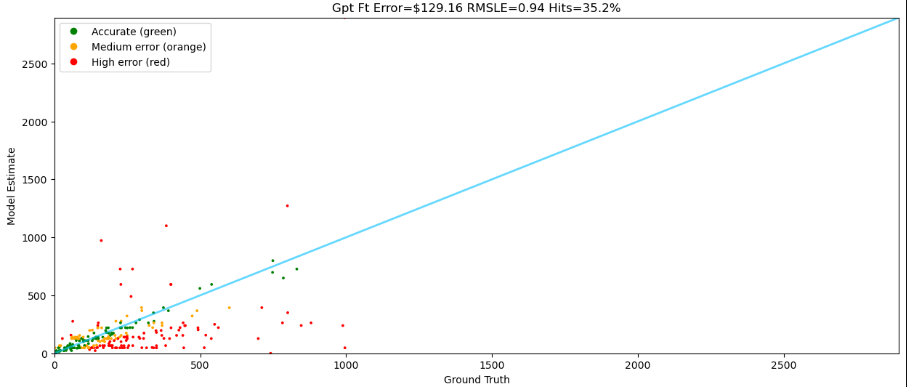

**Fine-tuning GPT-4o Mini led to worse performance than both its zero-shot and RAG-enhanced versions.**

⚠️ When Fine-Tuning Isn’t Needed:
- For tasks like price prediction, GPT-4o performs well with prompting alone — thanks to strong pretraining and generalization.
- 💡 Fine-tuning isn’t always better. Use it when prompting fails — not by default.

✅ **When Fine-Tuning Is Worth It (based on OpenAI’s own guidelines)**
- Custom tone/style – e.g., mimicking a brand voice or writing like a specific author
- More consistent output – e.g., always following a strict format
- Fix prompt failures – e.g., when multi-step instructions get ignored
- Handle edge cases – e.g., rare product types or weird inputs
- Teach new tasks – e.g., estimating prices in a custom format no model has seen before

---

Now that we’ve explored both frontier closed-source models and traditional ML, it’s time to turn to open-source.

🚀 **Next up: Fine-tuned LLaMA 3.1 8B (quantized)** — can it beat its base version, outperform GPT-4o Mini, or even challenge the big players?

🔍 Let’s find out in the [next notebook](https://github.com/lisekarimi/lexo/blob/main/09_part5_llama31_8b_quant.ipynb)